Epoch 1/100
38/38 [==============================] - 11s 116ms/step - loss: 0.0313
Epoch 2/100
38/38 [==============================] - 4s 117ms/step - loss: 0.0057
Epoch 3/100
38/38 [==============================] - 4s 114ms/step - loss: 0.0072
Epoch 4/100
38/38 [==============================] - 4s 116ms/step - loss: 0.0051
Epoch 5/100
38/38 [==============================] - 4s 116ms/step - loss: 0.0049
Epoch 6/100
38/38 [==============================] - 5s 135ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 5s 122ms/step - loss: 0.0048
Epoch 8/100
38/38 [==============================] - 6s 151ms/step - loss: 0.0047
Epoch 9/100
38/38 [==============================] - 9s 225ms/step - loss: 0.0042
Epoch 10/100
38/38 [==============================] - 8s 197ms/step - loss: 0.0042
Epoch 11/100
38/38 [==============================] - 7s 185ms/step - loss: 0.0044
Epoch 12/100
38/38 [==============================] - 7s 173ms/step - loss: 0.0041
Epoch 13/100

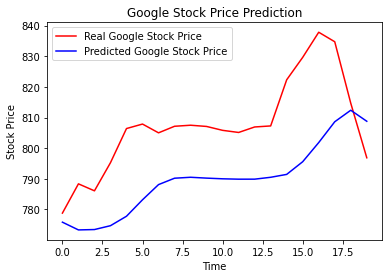

In [1]:
#RNN

#Part 1 - Data Preprocessing

#Imporing the necessary Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Importing Data

dataset_train = pd.read_csv('/content/Google_Stock_Price_Train.csv')

#Selecting column 1 to (2-1)
training_set = dataset_train.iloc[:,1:2].values

#Feature Scaling

#Standardization = x - x_bar / S.D(x)
#Normalization = x - min(x) / max(x) - min(x)  --> Recommended for RNN

from sklearn.preprocessing import MinMaxScaler
#feature_range = Range of scaled values

sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)

#We need to specify a data structure descibing what to remember

#Creating a data structure with 60 timesteps and 1 output. Estimating 60 takes trial and error

#To store previous 60 elements
X_train = []  
y_train = []

#Initial Index is 60 => Since we need 60 previous records

for i in range(60,1258):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train),np.array(y_train)

#Reshaping

#Dim 1 -> Number of Stock Prices, Dim2 -> Number of Time steps, Dim3 -> Number of Indicators
X_train = np.reshape(X_train, newshape=(X_train.shape[0],X_train.shape[1],1))

#Part 2: Building RNN

#Importing Keras Libraries and Packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#Initializing the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularizations

#units -> No of neurons in the Layer
#return_sequences -> To return a sequence of values for next LSTM layer
#input_shape -> First dimension will be taken care of the Layer itself
regressor.add( LSTM( units=50 , return_sequences=True, input_shape=(X_train.shape[1],1) ) )
#rate -> Dropout rate : Ignored during training (Generally 20%)
regressor.add( Dropout(rate=0.2) )

#Adding the second LSTM layer

#Input_shape is not needed since previous Layer has units specified
#We need higher dimensionality to capture complex patterns/features
regressor.add( LSTM( units=50 , return_sequences=True ) )
regressor.add( Dropout(rate=0.2) )

#Adding the Third LSTM layer

regressor.add( LSTM( units=50 , return_sequences=True ) )
regressor.add( Dropout(rate=0.2) )

#Adding the fourth LSTM layer

#return sequences is set to False
regressor.add( LSTM( units=50 ) )
regressor.add( Dropout(rate=0.2) )

# Adding the output layer

#Since dimension output is 1: Units
regressor.add( Dense( units=1 ) )

#Compiling the RNN

#RMSprop is an optimizer recommended for RNN
regressor.compile( optimizer='adam', loss='mean_squared_error' )

#Fitting the RNN to the Training set

regressor.fit( X_train, y_train, batch_size=32 , epochs=100 )

#Part 3 - Making Predictions and visualizing the results

#Getting the Real Stock Prices

dataset_test = pd.read_csv('/content/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:,1:2].values

#Getting the Predicted Stock Prices

dataset_total = pd.concat( (dataset_train['Open'],dataset_test['Open']), axis=0 )
#Since we need the previous 60 values
inputs = dataset_total[ len(dataset_total)-len(dataset_test) -60 :].values
#Reshaping to A Single Column
inputs = inputs.reshape( -1,1 )
#Only transform: Since fitting was already done to the train data
inputs = sc.transform(inputs)

#Creating a data structure with 60 timesteps

#To store previous 60 elements
X_test = []

#Initial Index is 60 => Since we need 60 previous records
#Final Index is 80 => Only 20 prdictions are needed

for i in range(60,80):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)

#Reshaping

#Dim 1 -> Number of Stock Prices, Dim2 -> Number of Time steps, Dim3 -> Number of Indicators
X_test = np.reshape(X_test, newshape=(X_test.shape[0],X_test.shape[1],1))

#Ready to make Predictions!!!

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#Visualizing the Final results

plt.plot(real_stock_price, color='red', label = "Real Google Stock Price")
plt.plot(predicted_stock_price, color='blue', label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price,predicted_stock_price))